In [3]:
%load_ext autoreload
%autoreload 2

import pathlib
import os

import flax
from flax import jax_utils
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import torch
import tensorflow as tf
import tqdm

import init2winit
import fastmri

import i2w

from fastmri.models import unet as t_unet
from fastmri.pl_modules import data_module
from fastmri.pl_modules import unet_module
from fastmri.data.transforms import UnetDataTransform
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri_examples.unet import train_unet_demo

from init2winit.model_lib import unet as f_unet
from init2winit.dataset_lib import fastmri_dataset
from init2winit.dataset_lib import data_utils
from init2winit.optimizer_lib import optimizers
from init2winit.optimizer_lib import transform

jax.devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[GpuDevice(id=0, process_index=0),
 GpuDevice(id=1, process_index=0),
 GpuDevice(id=2, process_index=0),
 GpuDevice(id=3, process_index=0),
 GpuDevice(id=4, process_index=0),
 GpuDevice(id=5, process_index=0),
 GpuDevice(id=6, process_index=0),
 GpuDevice(id=7, process_index=0)]

# Train step with lightning

In [2]:
data_path = pathlib.Path('../../')
challenge = 'singlecoil'
center_fractions = [0.08]
accelerations = [4]
mask_type = None  # Should be `random`, but tying out without
test_split = 'test'
batch_size = 8

lr = 0.001
lr_step_size = 40
lr_gamma = 0.1
weight_decay = 0.0

In [5]:
args = dict(accelerations=[4], accelerator='ddp', accumulate_grad_batches=None, amp_backend='native', amp_level=None, auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, batch_size=8, benchmark=False, callbacks=[<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f409795e090>], center_fractions=[0.08], challenge='singlecoil', chans=32, check_val_every_n_epoch=1, checkpoint_callback=None, combine_train_val=False, data_path=PosixPath('/home/dsuo'), default_root_dir=PosixPath('unet/unet_demo'), detect_anomaly=False, deterministic=True, devices=None, drop_prob=0.0, enable_checkpointing=True, enable_model_summary=True, enable_progress_bar=True, fast_dev_run=False, flush_logs_every_n_steps=None, gpus=8, gradient_clip_algorithm=None, gradient_clip_val=None, in_chans=1, ipus=None, limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gpu_memory=None, logger=True, lr=0.001, lr_gamma=0.1, lr_step_size=40, mask_type='random', max_epochs=50, max_steps=-1, max_time=None, min_epochs=None, min_steps=None, mode='train', move_metrics_to_cpu=False, multiple_trainloader_mode='max_size_cycle', num_log_images=16, num_nodes=1, num_pool_layers=4, num_processes=1, num_sanity_val_steps=2, num_workers=4, out_chans=1, overfit_batches=0.0, plugins=None, precision=32, prepare_data_per_node=None, process_position=0, profiler=None, progress_bar_refresh_rate=None, reload_dataloaders_every_epoch=False, reload_dataloaders_every_n_epochs=0, replace_sampler_ddp=False, resume_from_checkpoint=None, sample_rate=None, seed=42, stochastic_weight_avg=False, strategy=None, sync_batchnorm=False, terminate_on_nan=None, test_path=None, test_sample_rate=None, test_split='test', test_volume_sample_rate=None, tpu_cores=None, track_grad_norm=-1, use_dataset_cache_file=True, val_check_interval=1.0, val_sample_rate=None, val_volume_sample_rate=None, volume_sample_rate=None, weight_decay=0.0, weights_save_path=None, weights_summary='top')

SyntaxError: invalid syntax (3389336183.py, line 1)

In [4]:
# mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)
mask = None

train_transform = UnetDataTransform(challenge, mask_func=mask, use_seed=False)
val_transform = UnetDataTransform(challenge, mask_func=mask)
test_transform = UnetDataTransform(challenge)

dm8 = data_module.FastMriDataModule(
    data_path=data_path,
    challenge=challenge,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    test_split=test_split,
    batch_size=batch_size,
    num_workers=4,
)

dl8 = iter(dm8.train_dataloader())

## `fastmri`

In [5]:
t_model = unet_module.UnetModule()
t_opt, t_lr = t_model.configure_optimizers()
t_opt, t_lr = t_opt[0], t_lr[0]

## `init2winit`

In [6]:
f_model = f_unet.UNetModel(f_unet.DEFAULT_HPARAMS, {}, 'mean_absolute_error', 'image_reconstruction_metrics')
f_params = i2w.convert_params(t_model.unet, f_model.flax_module)

f_opt_init, f_opt_update = f_opt = optax.chain(transform.precondition_by_rms(decay=0.99), optax.scale_by_schedule(optax.piecewise_constant_schedule(init_value=-lr, boundaries_and_scales={lr_step_size: lr_gamma})))
f_opt_state = f_opt_init(f_params)

Abs sum diff: 0.106908776


In [7]:
def loss(params, image, y):
    return jnp.abs(f_model.flax_module.apply(params, image) - y).mean()

In [8]:
count = 0

# NOTE: no t_lr.step() because we're operating on steps now, not epochs.

data = []
for i, t_batch in enumerate(dl8):
    if count == 500:
        break
    t_opt.zero_grad()
    
    f_batch = i2w.create_batch(t_batch)
    
    t_fwd = t_model(t_batch.image).detach().numpy()
    f_fwd = np.array(f_model.flax_module.apply(f_params, f_batch['inputs']))
    
    delta = np.mean(np.abs(t_fwd - f_fwd))
    print(delta)
    
    t_loss = t_model.training_step(t_batch, i)
    t_loss.backward()
    t_opt.step()
    
    f_loss, grad = jax.value_and_grad(loss)(f_params, f_batch['inputs'].squeeze(), f_batch['targets'].squeeze())
    updates, f_opt_state = f_opt_update(grad, f_opt_state, f_params)
    f_params = optax.apply_updates(f_params, updates)
    
    print(i, t_loss.detach().numpy(), f_loss)
    data.append((delta, t_loss.detach().numpy(), f_loss))
    count += 1

1.2685695e-06


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/lightning.py:416: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  "You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet."
2022-05-06 09:59:08.546688: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[2,2,64,32]{1,0,2,3}, u8[0]{0}) custom-call(f32[8,320,320,32]{2,1,0,3}, f32[8,319,319,64]{2,1,0,3}), window={size=319x319 rhs_reversal=1x1}, dim_labels=f01b_i01o->01fb, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-05-06 09:59:14.801548: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algo

0.77097315 0.7709769
0.0013517988
0.7401474 0.74021363
0.0016815105
0.44114804 0.44111365
0.0076899137
0.59324723 0.5937931
0.019513814
0.52811617 0.52706534
0.007131211
0.2320315 0.23414299
0.008716685
0.22167912 0.22401088
0.014803146
0.234421 0.24090464
0.07691227
0.2514297 0.2171614
0.16626868
0.26448616 0.34635046
0.22980425
0.2564893 0.076450735
0.295882
0.2952155 0.13457654
0.13965632
0.20944826 0.13822912
0.23083389
0.07889843 0.18670942
0.2514738
0.14139497 0.16249292
0.051262606
0.11191578 0.102742895
0.042077564
0.14867985 0.12827799
0.054553434
0.11228439 0.09581647
0.07307418
0.1076875 0.14826345
0.03365475
0.11558832 0.11412029
0.032402825
0.07391179 0.059907377
0.03257545
0.10700479 0.09601495
0.039383125
0.110831186 0.092381544
0.04092995
0.15257925 0.14611232
0.02963134
0.089334905 0.078116335
0.035834156
0.0789841 0.07041183
0.026930885
0.07552831 0.0754396
0.034060266
0.12807387 0.11559083
0.02647954
0.17920868 0.17072345
0.04837981
0.09404108 0.095454134
0.05598439


0.035668194
0.034593374 0.032610245
0.03211461
0.033137094 0.02738017
0.03902137
0.036230057 0.024034653
0.051095486
0.076125726 0.06943658
0.064207025
0.03789912 0.078610666
0.092327766
0.05086655 0.08258552
0.083319835
0.11847964 0.08218915
0.12928607
0.11369906 0.07982976
0.11449556
0.09170601 0.06118897
0.040132135
0.052988432 0.05249328
0.07368919
0.0915298 0.05063532
0.05336171
0.050704256 0.05764279
0.04255611
0.0314479 0.048077215
0.03136945
0.033697266 0.036509145
0.059823394
0.069843486 0.04047183
0.036588017
0.037647672 0.042239275
0.038656756
0.056163963 0.049953748
0.016708517
0.025825033 0.030116782
0.029139142
0.033501476 0.030706048
0.027896253
0.030063424 0.024716772
0.031822555
0.038254485 0.029411115
0.052648447
0.08778435 0.087247
0.06108066
0.07515674 0.1181876
0.17316425
0.12939034 0.0740231
0.121869065
0.13610993 0.059566822
0.050187808
0.042635158 0.06302879
0.041974273
0.04835784 0.056069516
0.04130256
0.06963809 0.058143634
0.07034236
0.060456492 0.04088246
0.

KeyboardInterrupt: 

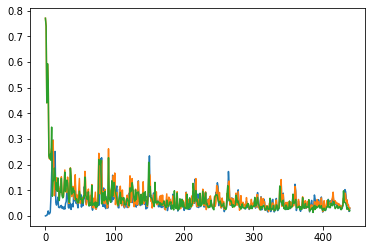

In [11]:
plt.plot(np.array(data))